In [1]:
import joblib
best_model = joblib.load('models/xgb_regressor_best_model.pkl')

In [4]:
import pandas as pd
import numpy as np


In [ ]:
x_train = pd.read_parquet('data/x_train.parquet')
x_test = pd.read_parquet('data/x_test.parquet')
y_train = pd.read_parquet('data/y_train.parquet')['y_train']
y_test = pd.read_parquet('data/y_test.parquet')['y_test']

In [11]:
# model prediction
y_pred_log = best_model.predict(x_test) 
y_pred = np.expm1(y_pred_log)
y_test_true = np.expm1(y_test)
y_train_true = np.expm1(y_train)

In [8]:
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

In [14]:
# If scores are consistent across folds → model generalizes well.
# If scores vary a lot → your model is sensitive to the data (possible high variance problem)
cv_scores = cross_val_score(best_model,x_train,y_train,scoring='neg_mean_squared_error',n_jobs=-1,cv=5)


In [15]:

cv_scores_rmse = np.sqrt(-cv_scores) #converts the neg_mean_squared_error to root mean squared error
print('Cross validation per fold: ',cv_scores_rmse) # consistent scores mean model generalizes well - low variance
print('Mean CV RMSE: ',cv_scores_rmse.mean()) # how much your model gets it wrong, on average
print('Std CV RMSE: ',cv_scores_rmse.std()) # low standard deviation means model generalizes well


Cross validation per fold:  [0.23922609 0.22585955 0.2201708  0.21842528 0.22307688]
Mean CV RMSE:  0.2253517210690847
Std CV RMSE:  0.007385777284784257


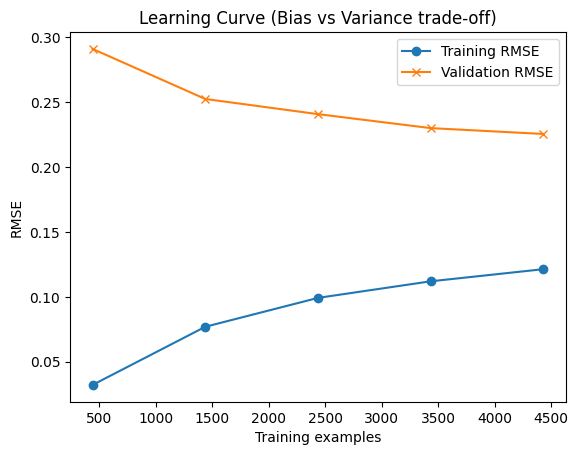

In [16]:
import matplotlib.pyplot as plt
#bias and variance trade-off
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model,x_train,y_train,cv=5,scoring='neg_mean_squared_error',n_jobs=-1,train_sizes=np.linspace(0.1,1.0,5)
)
train_rmse = np.sqrt(-train_scores.mean(axis=1)) #converts mse into rmse, averages the MSE's across the 5 folds
val_rmse = np.sqrt(-val_scores.mean(axis=1)) 

plt.plot(train_sizes,train_rmse,'o-',label='Training RMSE')
plt.plot(train_sizes,val_rmse,'x-',label='Validation RMSE')
plt.xlabel('Training examples')
plt.ylabel('RMSE')
plt.title('Learning Curve (Bias vs Variance trade-off)')
plt.legend()
plt.show()


In [ ]:

# underfitting - curve is almost flat, training and validation errors are high
# overfitting - training error is low, validation error is high, big gap between curves
# good fit - both errors are low, curves are close together

#high bias - underfitting (training error - high, validation error - high, learning curve - gap btwn curve is close and flat)
# - increase model complexity_add polynomial features
# - reduce regularization
# - train longer 

#high variance - overfitting (training error - low, validation error - high, gap btwn curve is wide apart)
# - get more training data
# - add regularization
# - simplify the model
# - add cross-validation
# - data augumentation, noise ingestion


In [ ]:
# residuals - difference between predicted and actual values
residuals = y_test - y_pred_log

import seaborn as sns
# residual plots
plt.figure(figsize=(12,7))
sns.scatterplot(x=y_pred_log,y=residuals)
plt.axhline(0,color='red',linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plots')
plt.show()
# ideal if residuals look like noise around 0
# systematic patterns equals bad model
# bigger errors around edges means model struggles with extreme values
#error distribution
plt.figure(figsize=(12,7))
sns.histplot(residuals,kde=True)
plt.axvline(color='red',linestyle='--')
plt.title('Distribution of residuals')
plt.show()


In [ ]:

# Good model if error is centered around 0
# bell curved shape equals good model
#error segmentation
results = pd.DataFrame({
    'y_true' : y_true_xgb,
    'y_pred' : y_pred_xgb
})
results['fuel'] = x_test['fuel']
results['owner'] = x_test['owner']
results['transmission'] = x_test['transmission']
results['mileage'] = x_test['mileage']
results['seats'] = x_test['seats']

eps = 1e-8
results['residual'] = results['y_true'] - results['y_pred']
results['abs_error'] = results['residual'].abs()
results['squared_error'] = results['residual']**2
results['ape'] = (results['abs_error']/np.maximum(results['y_true'],eps)) * 100.0

fuel_seg = (
    results.groupby('fuel',observed=True)
    .agg(
        n = ('y_true','size'),
        mae = ('abs_error','mean'),
        rmse = ('squared_error',lambda s: np.sqrt(s.mean())),
        mape = ('ape','median'),
        true_median = ('y_true','median')
    )
    .query('n >= 30')
    .sort_values('mae',ascending=False)
)
print("Top brands by MAE:\n", fuel_seg.head(10), "\n")
#robustness and stress testing
x_test_noisy = x_test.copy()
numeric = x_test_noisy.select_dtypes(include='number').columns
noise = np.random.normal(0,0.1,x_test_noisy[numeric].shape)
x_test_noisy[numeric] = x_test_noisy[numeric] + noise

x_test_noisy_pred = best_xgb.predict(x_test_noisy)

print('MSE for original prediction: ', mean_squared_error(y_test,y_pred_log_xgb))
print('MSE for noisy prediction : ',mean_squared_error(y_test,x_test_noisy_pred))

#small changes in model after adding noise - good robustness
#big changes in model after adding noise - fragile model
pipe_rf = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',RandomForestRegressor(random_state=42,n_jobs=1))
])
grid_params = {
    'model__n_estimators' : [50,100],
    'model__max_depth' : [None,20,25],
    'model__min_samples_split' : [2,5],
    'model__max_features' : ['sqrt',0.5],
    'preprocessor__num__poly__degree' : [1,2,3]
}
gs_rf = GridSearchCV(pipe_rf,grid_params,cv=cv,n_jobs=-1,verbose=2,return_train_score=True, refit=True)
print('Fitting Gridsearch for Random Forest (this may take a while) ... ')
gs_rf.fit(x_train,y_train)
print('\nBest params : ',gs_rf.best_params_)
print('\nBest CV Score: ',gs_rf.best_score_)
best_rf = gs_rf.best_estimator_
y_pred_rf = best_rf.predict(x_test)
print('\nRandom forest performance on test set')
rf_metrics = metrics(y_test,y_pred_rf,prefix='RF')
cv_scores = cross_val_score(best_rf, x_train, y_train, cv=cv,scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores)
print(f'CV_RMSE mean score: {cv_rmse.mean():.2f} (+/- {cv_rmse.std():.2f})')
cv_results_rf = pd.DataFrame(gs_rf.cv_results_).sort_values('mean_test_score',ascending=False)
print('Top RF CV results (Top 5) ...')
print(cv_results_rf[['params','mean_test_score','std_test_score']].head())jjjjjjj